In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
%matplotlib inline
import matplotlib.pyplot as plt
import os

In [2]:
df = pd.read_excel('ZENITHB.xlsx',index_col="Date",parse_dates=True)

In [3]:
df

,Close,Open,High,Low,Vol(millions)
Date,,,,,
2023-05-26,27.00,26.75,27.00,26.40,50.01
2023-05-25,26.75,26.75,26.80,26.60,39.40
2023-05-24,26.75,27.00,27.20,26.00,37.56
2023-05-23,27.00,26.45,27.00,26.25,59.00
2023-05-22,26.45,26.00,26.45,25.05,53.43
...,...,...,...,...,...
2012-01-27,12.10,12.01,12.22,12.01,117.01
2012-01-26,12.02,12.00,12.02,11.97,61.36
2012-01-25,12.00,12.00,12.10,11.95,46.58


<AxesSubplot:xlabel='Date'>

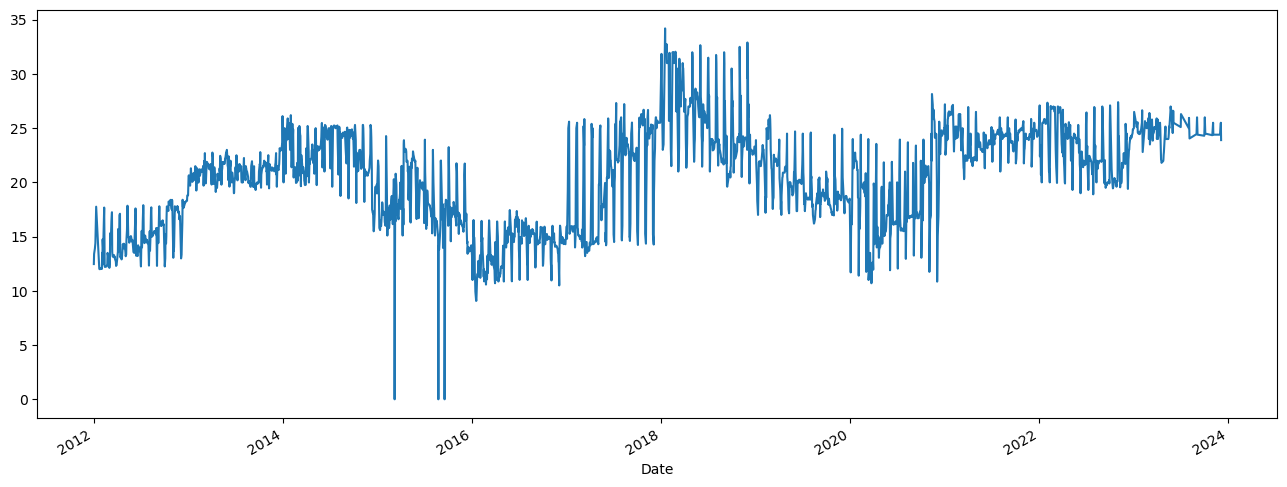

In [4]:
df['Open'].plot(figsize=(16,6))

In [5]:
df["Tomorrow"] = df["Close"].shift(-1)

In [6]:
df.head()

,Close,Open,High,Low,Vol(millions),Tomorrow
Date,,,,,,
2023-05-26,27.00,26.75,27.00,26.40,50.01,26.75
2023-05-25,26.75,26.75,26.80,26.60,39.40,26.75
2023-05-24,26.75,27.00,27.20,26.00,37.56,27.00
2023-05-23,27.00,26.45,27.00,26.25,59.00,26.45
2023-05-22,26.45,26.00,26.45,25.05,53.43,26.00


In [7]:
df["Target"] = (df["Tomorrow"] > df["Close"]).astype(int)

In [8]:
df.head()

,Close,Open,High,Low,Vol(millions),Tomorrow,Target
Date,,,,,,,
2023-05-26,27.00,26.75,27.00,26.40,50.01,26.75,0
2023-05-25,26.75,26.75,26.80,26.60,39.40,26.75,0
2023-05-24,26.75,27.00,27.20,26.00,37.56,27.00,1
2023-05-23,27.00,26.45,27.00,26.25,59.00,26.45,0
2023-05-22,26.45,26.00,26.45,25.05,53.43,26.00,0


In [9]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = df.iloc[:-100]
test = df.iloc[-100:]

predictors = ["Close", "Vol(millions)", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [10]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.7894736842105263

<AxesSubplot:xlabel='Date'>

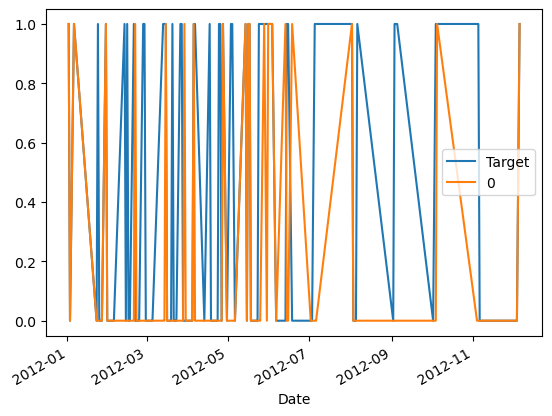

In [11]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [12]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [13]:
def backtest(data, model, predictors, start=2500, step=50):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [14]:
predictions = backtest(df, model, predictors)

In [15]:
predictions["Predictions"].value_counts()

0    218
1     89
Name: Predictions, dtype: int64

In [16]:
precision_score(predictions["Target"], predictions["Predictions"])

0.651685393258427

In [17]:
predictions["Target"].value_counts() / predictions.shape[0]

0    0.560261
1    0.439739
Name: Target, dtype: float64

In [18]:
predictions

,Target,Predictions
Date,,
2013-04-19,0,1
2013-04-18,1,1
2013-04-17,0,1
2013-04-16,1,1
2013-04-15,1,0
...,...,...
2012-01-27,0,0
2012-01-26,0,0
2012-01-25,0,0


In [19]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = df.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    df[ratio_column] = df["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    df[trend_column] = df.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors+= [ratio_column, trend_column]

In [75]:
df = df.dropna(subset=df.columns[df.columns != "Tomorrow"])

In [20]:
df

,Close,Open,High,Low,Vol(millions),Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
2019-10-05,20.00,20.00,20.25,19.95,16.64,20.00,0,1.007557,1.0,1.007557,2.0,1.033058,37.0,1.113449,117.0,0.926964,412.0
2019-09-05,20.00,20.45,20.40,20.00,28.61,20.45,1,1.000000,1.0,1.003009,2.0,1.031061,36.0,1.112236,117.0,0.927255,412.0
2019-08-05,20.45,20.55,20.80,20.40,32.22,20.55,1,1.011125,1.0,1.020969,2.0,1.052045,36.0,1.135897,118.0,0.948406,412.0
2019-07-05,20.55,20.90,20.90,20.55,22.11,20.90,1,1.002439,2.0,1.020357,3.0,1.055109,36.0,1.140058,119.0,0.953304,413.0
2019-06-05,20.90,21.00,21.15,20.60,10.49,21.00,1,1.008444,2.0,1.025515,4.0,1.070697,36.0,1.158062,119.0,0.969770,414.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-01-27,12.10,12.01,12.22,12.01,117.01,12.02,0,1.003733,1.0,0.996049,2.0,0.936134,23.0,0.776354,109.0,0.635003,467.0
2012-01-26,12.02,12.00,12.02,11.97,61.36,12.00,0,0.996683,1.0,0.991913,2.0,0.932144,23.0,0.773000,109.0,0.630811,466.0
2012-01-25,12.00,12.00,12.10,11.95,46.58,11.96,0,0.999167,0.0,0.990426,2.0,0.933005,22.0,0.773405,109.0,0.629781,465.0


In [21]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [22]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [ ]:
predictions["Predictions"].value_counts()

In [24]:
precision_score(predictions["Target"], predictions["Predictions"])

0.6593406593406593

In [25]:
predictions["Target"].value_counts() / predictions.shape[0]

0    0.558824
1    0.441176
Name: Target, dtype: float64

In [27]:
predictions.head(10)

,Target,Predictions
Date,,
2013-04-18,1,0
2013-04-17,0,0
2013-04-16,1,1
2013-04-15,1,0
2013-12-04,1,0
2013-11-04,0,0
2013-10-04,1,1
2013-09-04,1,1
2013-08-04,0,1
